# Network of networks

Networks where created, this networks have topologies and functions. The topological and dynamic distance was compared.

Each network has a name that corresponds to: 
* MOTIF: motif of network
* ID, ID: parameter of order
* MODEL: Number of model/function

Only comparisons between different networks where taken into account.

In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

Load data. The data is a list of edges with topological and dynamical distance.

In [2]:
# Load data
data = np.genfromtxt('distancias3nodos.csv', delimiter=',', dtype=np.int32)
# remove header
data = np.delete(data, 0, 0)

We will add a motif edge index and a color
1. m1-m1 blue
2. m1-m2 'cyan'
3. m1-m3 'DeepPink'
4. m1-m4 'magenta'
5. m2-m2 'green'
6. m2-m3 'Brown'
7. m2-m4 'Olive'
8. m3-m3 'Orange'
9. m3-m4 'OrangeRed'
10. m4-m4 'red'


In [3]:
def edges2index( data ):
    index = [str(d[0]) + str(d[1]) for d in data ]
    index = [d[0]+d[4]+d[1]+d[5]+d[2]+d[6]+d[3]+d[7] for d in index ]
    index = [int(d) for d in index]
    return index

def edges2motifcolor( data ):
    color = []
    for d in data:
        i = int(str(d[0])[0] + str(d[1])[0])
        if i == 11: color.append('blue')
        if i == 12: color.append('cyan')
        if i == 13: color.append('deeppink')
        if i == 14: color.append('m')
        if i == 22: color.append('green')
        if i == 23: color.append('brown')
        if i == 24: color.append('olive')
        if i == 33: color.append('orange')
        if i == 34: color.append('orangered')
        if i == 44: color.append('r')
    return color

## Distance distribution

Distribution of topological distances

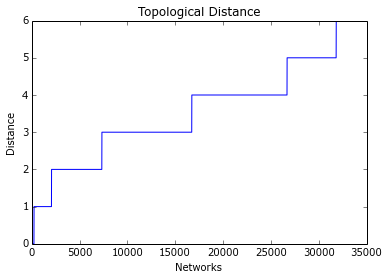

In [4]:
d_top = data[:,2]
plt.plot(sorted(d_top), 'b')
plt.xlabel('Networks')
plt.ylabel('Distance')
plt.title('Topological Distance')
plt.show()

Distribution of dynamic distances

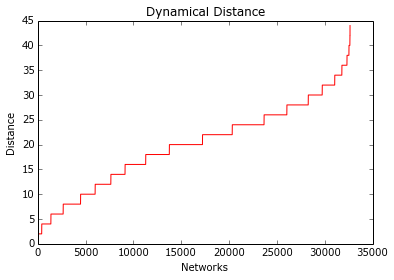

In [5]:
d_dyn = data[:,3]
plt.xlabel('Networks')
plt.ylabel('Distance')
plt.title('Dynamical Distance')
plt.plot(sorted(d_dyn), 'r') #All distances

plt.show()

* Does it follows a distribution?

Separate by topological distance

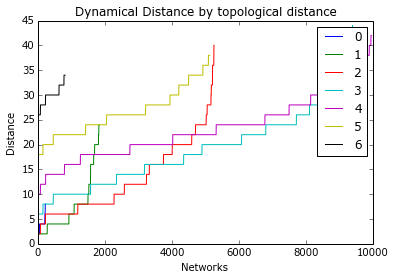

In [6]:
for i in range(0, max(data[:,2])+1): #sort by topological distance
    data_i = data[data[:,2]==i]
    d_dyn_i = data_i[:,3]
    plt.plot(sorted(d_dyn_i), label=str(i))
plt.xlabel('Networks')
plt.ylabel('Distance')
plt.title('Dynamical Distance by topological distance')
plt.legend()

plt.show()

Topological vs dynamic distances

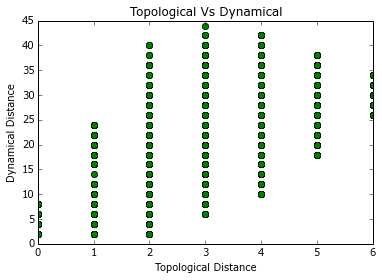

In [7]:
plt.plot(d_top, d_dyn, 'go')
plt.xlabel('Topological Distance')
plt.ylabel('Dynamical Distance')
plt.title('Topological Vs Dynamical')
plt.show()

This is confusing, maybe add a third axis and sort in a better way...

We'll plot by index, intercalating the numbers, so 1001-1021 -> 11000211

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


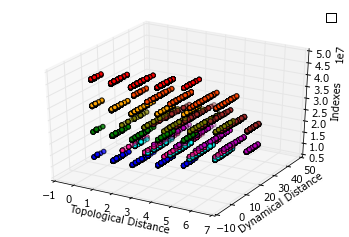

In [8]:
from mpl_toolkits.mplot3d import Axes3D

index = edges2index(data)
color = edges2motifcolor(data)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(d_top, d_dyn, index, c=color)
ax.legend('Distances by index')
ax.set_xlabel('Topological Distance')
ax.set_ylabel('Dynamical Distance')
ax.set_zlabel('Indexes')

plt.show()

Well... Comparisons between same motifs have smaller distances... the rest is a disaster.

Lets filter to obtain only the edges with topological distance 0 and 2

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


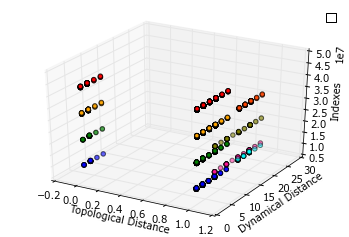

In [9]:
data0 = data[data[:,2]<=1]

index0 = edges2index(data0)
color0 = edges2motifcolor(data0)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(data0[:,2], data0[:,3], index0, c=color0)
ax.legend('D_top 0 by index')
ax.set_xlabel('Topological Distance')
ax.set_ylabel('Dynamical Distance')
ax.set_zlabel('Indexes')

plt.show()

## Network

First,lets create a network

Nodes are networks:
* name
* motif
* func _(loop functionality)_
* f_color

Edges:
* w_top
* w_dyn
* index _(mixed index of nodes)_
* m_color _(color of motifs)_

In [10]:
import networkx as nx

G = nx.Graph()

#first, create nodes with funcionality
f = open('Networks_Functionaliy_Results.csv','r')
f.readline() #remove header
for line in f:
    line = line.strip().split(',')
    if line[1] == '': #no func
        G.add_node(int(line[0]), motif=int(line[0][0]),
                  func=line[1], f_color='black')
    elif line[1][-1] == 'A': #func A
        G.add_node(int(line[0]), motif=int(line[0][0]),
                  func=line[1], f_color='red')
    elif line[1][-1] == 'B': #func B
        G.add_node(int(line[0]), motif=int(line[0][0]),
                  func=line[1], f_color='green')
f.close()
#G.nodes(data=True)

#lets add edges, no threshold (yet)
for d in zip(data.tolist(), edges2index(data), edges2motifcolor(data)):
    G.add_edge(d[0][0], d[0][1], 
               w_top=d[0][2], w_dyn=d[0][3],
               index=d[1], m_color=d[2])

#G.nodes(data=True)
#G.edges(data=True)

First, lets threshold by d_top = 0 and plot. We'll color with motif and label with funloops

In [11]:
G0 = G.copy()
# remove edgens with d_top > 0
del_edges = [ (u,v,d) for u,v,d in G.edges(data=True) if d['w_top']!=0]
G0.remove_edges_from(del_edges)
# remove unconnected nodes
deg = G0.degree()
del_nodes = [n for n in deg if deg[n] == 0]
G0.remove_nodes_from(del_nodes)

#G0.edges(data=True)
#G0.nodes(data=True)

/usr/lib/python3/dist-packages/matplotlib/collections.py:609: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


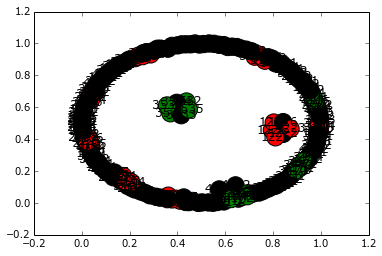

In [12]:
label = [G.node[n]['motif'] for n in G0.nodes()]
color = [G.node[n]['f_color'] for n in G0.nodes()]

nx.draw_networkx(G0, #pos=pos, 
                 node_color=color, with_labels=label)

Horrible plotting, and graphviz is broken. Lets just plot in js later.

Epileptic trees: fun loops only appear in networks that have 6 possible models, and usually only in 4/6 models

It would be worthy to plot all networks with a functionality and compare transition tables

Lets see how thresholding affects the number of components.

First, topological distance

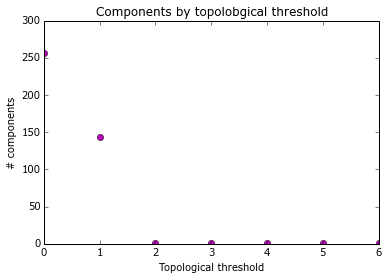

In [13]:
for i in range(0, max(data[:,2]+1)): #sort by topological distance
    Gi = G.copy()
    # remove edgens with d_top > 0
    del_edges = [ (u,v,d) for u,v,d in G.edges(data=True) if d['w_top']>=i]
    Gi.remove_edges_from(del_edges)
    n = nx.number_connected_components(Gi)
    plt.plot(i, n, 'mo')

plt.xlabel('Topological threshold')
plt.ylabel('# components')
plt.title('Components by topolobgical threshold')

plt.show()

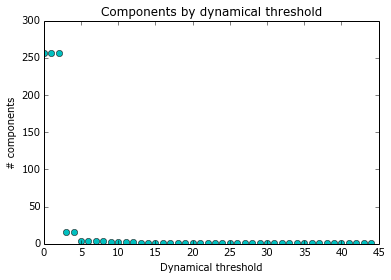

In [14]:
for i in range(0, max(data[:,3]+1)): #sort by topological distance
    Gi = G.copy()
    # remove edgens with d_top > 0
    del_edges = [ (u,v,d) for u,v,d in G.edges(data=True) if d['w_dyn']>=i]
    Gi.remove_edges_from(del_edges)
    n = nx.number_connected_components(Gi)
    plt.plot(i, n, 'co')

plt.xlabel('Dynamical threshold')
plt.ylabel('# components')
plt.title('Components by dynamical threshold')

plt.show()

## Dendogram

Clustering!

First, lets get the matrixes and remove nans. The matrixes are in the order of G.nodes()

In [15]:
D_top = np.array(nx.to_numpy_matrix(G, weight='w_top', nonedge=None))
D_top = np.nan_to_num(D_top)
D_dyn = np.array(nx.to_numpy_matrix(G, weight='w_dyn', nonedge=None))
D_dyn = np.nan_to_num(D_dyn)

Cluster and verify clustering

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(D_dyn,'ward')
Z

#Verify clustering, 1 is ideal
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(D_dyn))
c

0.88233013376558944

Could be worse. D_dyn is .882; D_top is .415, which is unaceptable. 'Ward' gives best results.

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


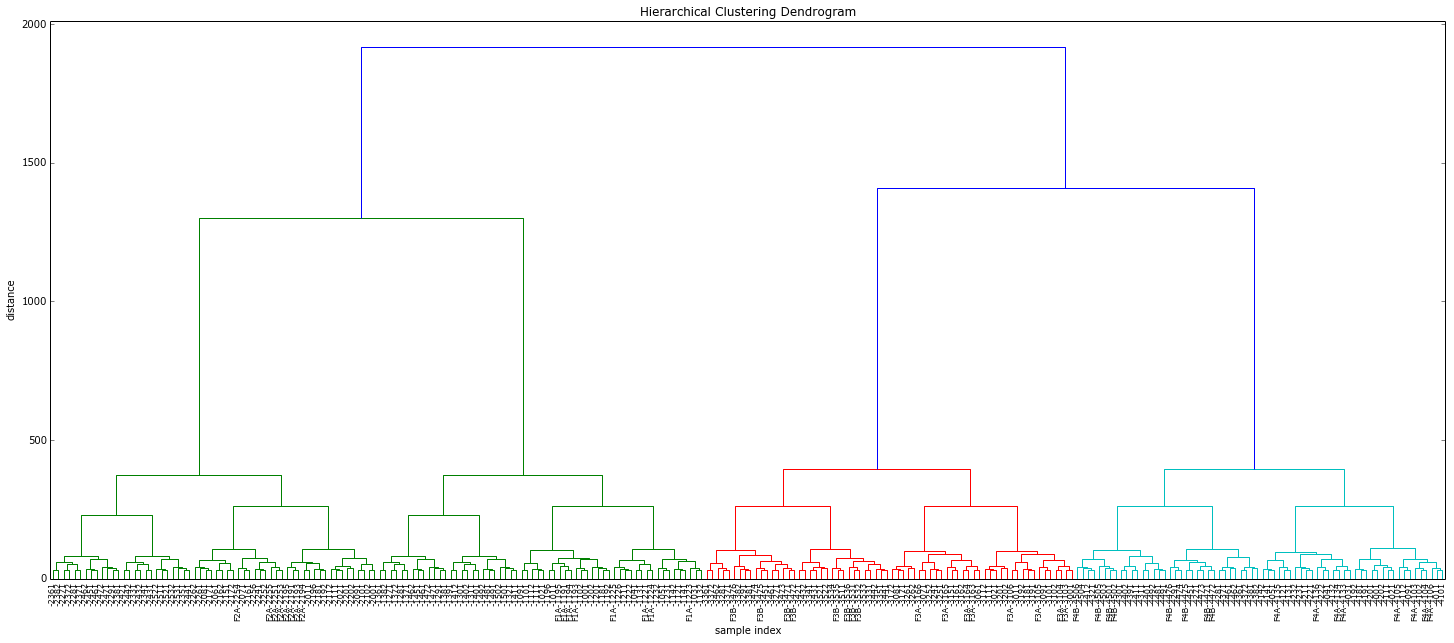

In [17]:
node_labels = list(G.nodes())
node_labels = [G.node[n]['func']+'-'+str(n) for n in node_labels]

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    labels=node_labels,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

It groups by motif, and most (but not all) nets with the same topology are near. I recomend opening the image in new tab for checking.

I can add a heatmap, but I'm not sure it would add anything interesting.

There is not a clear distribution in the functional loops

Note: consider truncating the dendogram, basicaly, do I need to separate in clusters?

## Fun Loops!

All the networks with loop functionality have 6 valid models, 4 with fun loop and 2 without (amargadas).